# The Data & The Goal
## The Goal
The ultimate goal of your algorithm is to determine if a link exists or not in the original network. In file solutionInput.csv you are provided a list of links. You should be able to output, for each link, a prediction: 1 if you believe the links exists in the original network; 0 if you believe the links does not exist in the original network. solutionInput.csv contains a total of 970 links: 485 exist in the original network (positive examples); 485 do not exist in the original network (negative examples). Your ultimate goal is to develop an algorithm that achieves high accuracy in this test data. An example of output that your program should provide is given in file predictions.csv Download predictions.csv.

## The Data

The base dataset to use consists of a (synthetic) social network with 1000 nodes and 4368 links. This network was generated by removing 10% of the links of an original network. Your task is to accurately guess whether a link given as an input belongs (or not) to the original network. All needed data can be found in the following zip file Download zip file.

* Network data: 
Each node is numbered from 0 to N-1, where N is the number of nodes in the network. The network structure is provided as a list of edges (edges_train.edgelist). In this file, each line corresponds to an edge (or link): int1,int2 where int1 and int2 correspond to the identification of each node connected by the edge. The network is assumed to be undirected (i.e., if a connection between nodes 1 and 2 exists in the file, the connection 2 to 1 is also assumed to exist).

* Node data: Each node is characterised by a categorical feature that can take 5 possible values (d, c, e, f, g). These might constitute a sensitive attribute (e.g., political affiliation, personal preferences, demographic data...). The feature of each node is provided in a .csv file (attributes.csv). In this file, each line corresponds to a node and the value in a given line corresponds to the feature of the corresponding node. 
  
* Final test data: The ultimate goal of your algorithm is to determine if a link exists or not in the original network. In file solutionInput.csv you are provided a list of links. You should be able to output, for each link, a prediction: 1 if you believe the links exists in the original network; 0 if you believe the links does not exist in the original network. solutionInput.csv contains a total of 970 links: 485 exist in the original network (positive examples); 485 do not exist in the original network (negative examples). Your ultimate goal is to develop an algorithm that achieves high accuracy in this test data. An example of output that your program should provide is given in file predictions.csv Download predictions.csv.

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

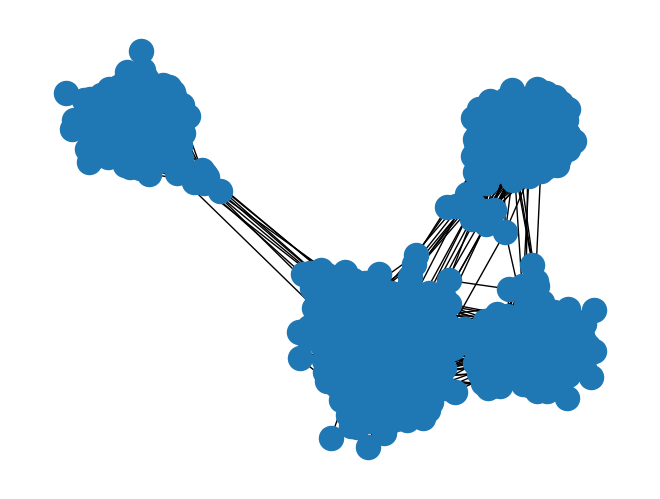

In [2]:
 # load and plot graph data
train_data_path = "edges_train.edgelist"
G = nx.read_edgelist(train_data_path, data=False, nodetype = int, delimiter=',')
# Lets displace nodes following a Directed Force algorithm (remember Lecture 4, on Data Viz, and Lab 2 Aux)
pos = nx.spring_layout(G)

# Draw the original graph
nx.draw(G, pos=pos)  

In [3]:
# load and plot attributes
train_attribute_path = "attributes.csv"
df = pd.read_csv(train_attribute_path, index_col=0)
df.head()

,attribute
ID,
0,c
1,c
2,c
3,c
4,c


# 1. Feature Engineering
Feature engineering: First you should be able to import network data and define the features you believe are relevant to predict links in social networks. The data we will provide you consist of a social network where some links were removed. Each node will also be characterised by a categorical feature. Examples of important features might be the class that nodes belong to, or the number of common connections between nodes.

In [4]:
# Strategy: Define a lot of possible features, 
# and use a method similar to the step-up / step-down method as disucssed in SSO class 
# to select the best features?

class FeatureGenerator:
    """
    This class is used to generate features for the link prediction problem.
    It takes as input a graph and a dataframe of attributes associated with the nodes of the graph.
    
    """
    def __init__(self, G, df):
        self.G = G
        self.df = df
        self.number_of_nodes = len(list(G.nodes))
        self.number_of_edges = len(list(G.edges))
        self.pa_matrix = self._build_preferential_attachment_matrix()
       
        
    # This method is private, as it is only a helper function used by the constructor to build the PA matrix. 
    # Building the matrix beforehand and storing it is more efficient than computing it every time we want to compute the preferential attachment between two nodes.
    def _build_preferential_attachment_matrix(self):
        pa = np.zeros((self.number_of_nodes,self.number_of_nodes))
        preds = nx.preferential_attachment(self.G, [(i,j) for i in range(self.number_of_nodes) for j in range(self.number_of_nodes)])
        for u, v, p in preds:
            pa[u,v] = p
        return pa


    def preferential_attachment_between(self, i, j) -> float:
        return self.pa_matrix[i,j]
    
    def shortest_path_between(self, i, j) -> int:
        return nx.shortest_path_length(self.G, source=i, target=j)
    
    def n_common_neighbours_between(self, i, j) -> int:
        return len(list(nx.common_neighbors(self.G, i, j))) # the method provides a generator, so we need to wrap it inside a list to compute its length.
 
    def abs_difference_in_degree_between(self, i, j) -> float:
        return abs(self.G.degree(i) - self.G.degree(j))
    
    def have_same_attribute_value(self, i, j) -> bool:
        return self.df.loc[i, "attribute"] == self.df.loc[j, "attribute"]


In [5]:
fg = FeatureGenerator(G, df)


# sg.generate_positive_samples()

In [6]:
fg.preferential_attachment_between(0, 1)
fg.have_same_attribute_value(0, 9)

False

# 2. Defining a training, validation and test set.

Once you have defined your feature space, you have to create your training, validation and test set. Your training set should be composed of positive examples (i.e., edges that exist in the network that was provided to you) and corresponding features. Your training set should also be composed of negative examples (i.e., edges that do not exist in the network provided). You will need to decide the ratio of positive and negative examples to include in your training set. You also have to decide about the split between training, validation and test set to train and select your best model. 

## 2.1 Preparing positive and negative samples

In [7]:
class SampleGenerator:
    def __init__(self, feature_generator):
        self.fg = feature_generator
    
       ## feature vectors
    def generate_feature_vector(self, i, j) -> np.array:
        return np.array([
            self.fg.preferential_attachment_between(i, j),
            self.fg.shortest_path_between(i, j),
            self.fg.n_common_neighbours_between(i, j),
            self.fg.abs_difference_in_degree_between(i, j),
            self.fg.have_same_attribute_value(i, j)
        ])
        
    def generate_positive_samples(self) -> (np.array, np.array):
        X = []
        Y = []
        for i, j in self.fg.G.edges:
            X.append(self.generate_feature_vector(i, j))
            Y.append(1)
        return np.array(X), np.array(Y)
    def generate_negative_samples(self, n=-1) -> (np.array, np.array):
        # per default, use the same number of negative samples as there are positive samples
        if n <= 0:
            n = self.fg.number_of_edges
        X = []
        Y = []
        for _ in range(n):
            i = np.random.randint(self.fg.number_of_nodes)
            j = np.random.randint(self.fg.number_of_nodes)

            # Make sure we get a node pair that is not in the graph
            while self.fg.G.has_edge(i,j) or i == j:
                i = np.random.randint(self.fg.number_of_nodes)
                j = np.random.randint(self.fg.number_of_nodes)

            X.append(self.generate_feature_vector(i, j))
            Y.append(0)
            
        return np.array(X), np.array(Y)
    
    # TODO:
    # let's add as many meaningful features as we can think of; then we can e.g. use step-up / step-down feature selection to select the best features.
    # also see the TODO method below.
    def new_feature():
        """
        To add another feature to the feature vector:
        (1) Add a new method to the FeatureGenerator class that implements the feature
        (2) Add the new feature to the generate_feature_vector method of the SampleGenerator class
        
    
        
        """
        
        pass
    
    # TODO: 
    def TODO(): 
        """
        We should probably add some logic so we can toggle which features we want to use.
        In the end, we want to create the best feature set, for example through step-up / step-down feature selection.
        
        """
        pass
            


In [8]:
sg = SampleGenerator(fg)

## 2.2 Prepare train, validation, and test set splits

In [11]:
X_pos, Y_pos = sg.generate_positive_samples()
X_neg, Y_neg = sg.generate_negative_samples()

# assert we use all positive examples (i.e. use all exisiting edges in the graph to train our model).
# The assignment states there should be 4368 edges in our training graph.
assert(X_pos.shape[0] == 4368) 

# assert we have a good balance between positive and negative samples
assert X_pos.shape == X_neg.shape, f"{X_pos.shape} != {X_neg.shape}"
# sanity check
assert(Y_pos.shape == Y_neg.shape)

# The final training set should contain both positive and negative samples.
X = X_pos + X_neg
Y = Y_pos + Y_neg



In [12]:
# Since we have a singificant number of of datapoints (about 8K), we can use a traditional 80/10/10 split for training, validation, and test set.
# So we don't need to perform k-fold cross validation, which reduces the complexity of our code.
# Since sklearn does not seem to provide a method to split the data into 3 sets, we can just use the train_test_split method twice.
TRAIN_SPLIT = .8
VAL_SPLIT = .1
TEST_SPLIT = .1
RANDOM_STATE = 42
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1, "let's not drop valuable data"

X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=TEST_SPLIT, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=VAL_SPLIT, random_state=RANDOM_STATE)


# 3. Model selection and validation
Once you have the required training and validation set, you have to select a model to be trained. You must use one of the methods discussed in the lectures (more complex models will not lead to higher performance, given the characteristics of the data we will provide you).


# 4. Application and test
Once you trained and validated your model, your solution should be able to decide if a (missing) link exists or not in a network. You will be welcome to submit your guesses to a Kaggle competition (details below). 
Note that we provide an auxiliary notebook Download auxiliary notebook (and auxiliary files Download files) that can greatly help you in the previous steps. 